In [12]:
from sacrebleu.metrics import BLEU
from bert_score import BERTScorer
from nltk.translate.meteor_score import meteor_score
from nltk.translate.chrf_score import sentence_chrf

In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import boto3
from botocore.exceptions import ClientError

def translate(text, target_language="Spanish"):
    """
    Translate text using AWS Bedrock Converse API
    
    Args:
        text (str): Text to translate
        target_language (str): Target language for translation
    
    Returns:
        str: Translated text
    """
    # Initialize the Bedrock Runtime client
    client = boto3.client("bedrock-runtime")
    
    # Set the model ID
    model_id = "openai.gpt-oss-20b-1:0"
    
    # Set up messages for translation
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "text": f"Translate the following text to {target_language}:\n\n{text}"
                }
            ]
        }
    ]
    
    system = [
        {
            "text": "You are a professional translator. Provide only the translated text without any additional explanation or commentary."
        }
    ]
    
    try:
        # Send the message to the model
        response = client.converse(
            modelId=model_id,
            messages=messages,
            system=system,
            inferenceConfig={
                "maxTokens": 500, 
                "temperature": 0.3,  # Lower temperature for more consistent translations
                "topP": 0.9
            },
        )
        
        # Extract the translated text
        translated_text = ""
        for content_block in response["output"]["message"]["content"]:
            if "text" in content_block:
                translated_text += content_block["text"]
        
        return translated_text.strip()
        
    except (ClientError, Exception) as e:
        print(f"ERROR: Can't invoke '{model_id}'. Reason: {e}")
        return None

In [15]:
def evaluate_translation(references, translations):
    """
    Evaluate multiple translation pairs and return individual + average scores
    
    Args:
        references (list): List of reference translations
        translations (list): List of model translations
    
    Returns:
        dict: Individual scores per pair + averaged scores
    """
    if len(references) != len(translations):
        raise ValueError("References and translations must have same length")
    
    individual_scores = []
    all_bleu_scores = []
    all_bert_scores = []
    all_meteor_scores = []
    all_chrf_scores = []
    
    # Initialize BERTScorer once for efficiency
    scorer = BERTScorer(model_type='bert-base-uncased', lang='en')
    
    print(f"Evaluating {len(references)} translation pairs...\n")
    
    for i, (reference_text, translated_text) in enumerate(zip(references, translations)):
        print(f"=== Pair {i+1} ===")
        print(f"Reference: {reference_text}")
        print(f"Translation: {translated_text}")
        
        # BLEU Score
        bleu_score = BLEU().corpus_score([translated_text], [[reference_text]]).score
        
        # BERTScore
        P, R, F1 = scorer.score([translated_text], [reference_text])
        bert_f1 = F1.mean().item()
        
        # METEOR Score
        translated_tokens = translated_text.split()
        reference_tokens = [reference_text.split()]
        meteor_result = meteor_score(reference_tokens, translated_tokens)
        
        # ChrF Score
        chrf_result = sentence_chrf(
            reference=reference_text,
            hypothesis=translated_text,
            min_len=1,
            max_len=6,
            beta=3.0
        )
        
        # Store individual scores
        pair_scores = {
            "BLEU": bleu_score,
            "BERTScore_F1": bert_f1,
            "METEOR": meteor_result,
            "ChrF": chrf_result
        }
        individual_scores.append(pair_scores)
        
        # Collect for averaging
        all_bleu_scores.append(bleu_score)
        all_bert_scores.append(bert_f1)
        all_meteor_scores.append(meteor_result)
        all_chrf_scores.append(chrf_result)
        
        print(f"BLEU: {bleu_score:.4f}")
        print(f"BERTScore F1: {bert_f1:.4f}")
        print(f"METEOR: {meteor_result:.4f}")
        print(f"ChrF: {chrf_result:.4f}")
        print("-" * 50)
    
    # Calculate averages
    avg_scores = {
        "BLEU": sum(all_bleu_scores) / len(all_bleu_scores),
        "BERTScore_F1": sum(all_bert_scores) / len(all_bert_scores),
        "METEOR": sum(all_meteor_scores) / len(all_meteor_scores),
        "ChrF": sum(all_chrf_scores) / len(all_chrf_scores)
    }
    
    print("\n=== AVERAGE SCORES ===")
    for metric, score in avg_scores.items():
        print(f"{metric}: {score:.4f}")
    
    return {
        "individual_scores": individual_scores,
        "average_scores": avg_scores,
        "num_pairs": len(references)
    }

In [5]:
# Load a real translation dataset for evaluation
from datasets import load_dataset

def load_translation_data(language_pair="de", dataset_name="wmt14", split="test", max_samples=10):
    """
    Load translation dataset for evaluation
    
    Args:
        language_pair (str): Target language (de, fr, es, etc.)
        dataset_name (str): Dataset to use (wmt14, opus_books, etc.)
        split (str): Dataset split (test, validation)
        max_samples (int): Number of samples to load
    
    Returns:
        tuple: (source_texts, reference_translations)
    """
    try:
        # Load WMT14 EN->DE as example
        if dataset_name == "wmt14":
            dataset = load_dataset("wmt14", f"de-en", split=split)
        elif dataset_name == "opus_books":
            dataset = load_dataset("opus_books", f"en-{language_pair}", split="train")
        
        # Extract English and target language texts
        source_texts = []
        reference_translations = []
        
        for i, example in enumerate(dataset):
            if i >= max_samples:
                break
                
            if dataset_name == "wmt14":
                source_texts.append(example['translation']['en'])
                reference_translations.append(example['translation']['de'])
            elif dataset_name == "opus_books":
                source_texts.append(example['translation']['en'])
                reference_translations.append(example['translation'][language_pair])
        
        return source_texts, reference_translations
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return [], []

# Example usage - load sample data
print("Loading translation dataset...")
english_texts, german_references = load_translation_data(language_pair="de", max_samples=3)

for i, (en, de) in enumerate(zip(english_texts, german_references)):
    print(f"\nSample {i+1}:")
    print(f"English: {en}")
    print(f"German Reference: {de}")
    print("-" * 50)

Loading translation dataset...

Sample 1:
English: Gutach: Increased safety for pedestrians
German Reference: Gutach: Noch mehr Sicherheit für Fußgänger
--------------------------------------------------

Sample 2:
English: They are not even 100 metres apart: On Tuesday, the new B 33 pedestrian lights in Dorfparkplatz in Gutach became operational - within view of the existing Town Hall traffic lights.
German Reference: Sie stehen keine 100 Meter voneinander entfernt: Am Dienstag ist in Gutach die neue B 33-Fußgängerampel am Dorfparkplatz in Betrieb genommen worden - in Sichtweite der älteren Rathausampel.
--------------------------------------------------

Sample 3:
English: Two sets of lights so close to one another: intentional or just a silly error?
German Reference: Zwei Anlagen so nah beieinander: Absicht oder Schildbürgerstreich?
--------------------------------------------------


In [8]:
# run translation to get preds
preds = [translate(text, "German") for text in english_texts]

In [9]:
preds

['Gutach: Erhöhte Sicherheit für Fußgänger',
 'Sie sind nicht einmal 100\u202fMeter voneinander entfernt: Am Dienstag wurden die neuen B\u202f33‑Fußgängerampeln im Dorfparkplatz in Gutach in Betrieb genommen – im Blickfeld der bestehenden Rathausampeln.',
 'Zwei Lichtgruppen so nah beieinander: absichtlich oder einfach ein dummer Fehler?']

In [19]:
# run eval on preds vs refs
results = evaluate_translation(german_references, preds)
results

Evaluating 3 translation pairs...

=== Pair 1 ===
Reference: Gutach: Noch mehr Sicherheit für Fußgänger
Translation: Gutach: Erhöhte Sicherheit für Fußgänger
BLEU: 32.1594
BERTScore F1: 0.9156
METEOR: 0.6356
ChrF: 0.7125
--------------------------------------------------
=== Pair 2 ===
Reference: Sie stehen keine 100 Meter voneinander entfernt: Am Dienstag ist in Gutach die neue B 33-Fußgängerampel am Dorfparkplatz in Betrieb genommen worden - in Sichtweite der älteren Rathausampel.
Translation: Sie sind nicht einmal 100 Meter voneinander entfernt: Am Dienstag wurden die neuen B 33‑Fußgängerampeln im Dorfparkplatz in Gutach in Betrieb genommen – im Blickfeld der bestehenden Rathausampeln.
BLEU: 26.6322
BERTScore F1: 0.8807
METEOR: 0.4786
ChrF: 0.6873
--------------------------------------------------
=== Pair 3 ===
Reference: Zwei Anlagen so nah beieinander: Absicht oder Schildbürgerstreich?
Translation: Zwei Lichtgruppen so nah beieinander: absichtlich oder einfach ein dummer Fehler?


{'individual_scores': [{'BLEU': 32.159351091190125,
   'BERTScore_F1': 0.9155959486961365,
   'METEOR': 0.635593220338983,
   'ChrF': 0.7125176153510376},
  {'BLEU': 26.632240818317527,
   'BERTScore_F1': 0.8807048201560974,
   'METEOR': 0.4785853794642857,
   'ChrF': 0.6872570149490133},
  {'BLEU': 22.242469397936766,
   'BERTScore_F1': 0.822144091129303,
   'METEOR': 0.5373493975903614,
   'ChrF': 0.4767140363625319}],
 'average_scores': {'BLEU': 27.01135376914814,
  'BERTScore_F1': 0.872814953327179,
  'METEOR': 0.5505093324645434,
  'ChrF': 0.625496222220861},
 'num_pairs': 3}

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_translation_metrics(results):
    """
    Create visualizations for translation evaluation results
    
    Args:
        results (dict): Results from evaluate_translation function
    """
    individual_scores = results['individual_scores']
    average_scores = results['average_scores']
    num_pairs = results['num_pairs']
    
    # Extract metrics data
    metrics = ['BLEU', 'BERTScore_F1', 'METEOR', 'ChrF']
    pair_numbers = list(range(1, num_pairs + 1))
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Individual scores per pair (line plot)
    for metric in metrics:
        scores = [pair[metric] for pair in individual_scores]
        ax1.plot(pair_numbers, scores, marker='o', label=metric, linewidth=2)
    
    ax1.set_xlabel('Translation Pair')
    ax1.set_ylabel('Score')
    ax1.set_title('Individual Scores per Translation Pair')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(pair_numbers)
    
    # 2. Average scores bar chart
    avg_values = [average_scores[metric] for metric in metrics]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    bars = ax2.bar(metrics, avg_values, color=colors, alpha=0.7)
    
    # Add value labels on bars
    for bar, value in zip(bars, avg_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_ylabel('Average Score')
    ax2.set_title('Average Performance Across All Metrics')
    ax2.set_ylim(0, max(avg_values) * 1.15)
    
    # 3. Radar/Spider chart showing metric balance
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    ax3.remove()  # Remove the subplot
    ax3 = fig.add_subplot(2, 2, 3, projection='polar')
    
    # Plot each translation pair
    colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for i, pair_scores in enumerate(individual_scores):
        values = [pair_scores[metric] for metric in metrics]
        values += values[:1]  # Complete the circle
        
        ax3.plot(angles, values, 'o-', linewidth=2, 
                label=f'Pair {i+1}', color=colors_radar[i % len(colors_radar)])
        ax3.fill(angles, values, alpha=0.1, color=colors_radar[i % len(colors_radar)])
    
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(metrics)
    ax3.set_title('Translation Performance Radar Chart', pad=20)
    ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax3.set_ylim(0, 1)
    
    # 4. Box plot showing score distribution
    score_data = []
    for metric in metrics:
        scores = [pair[metric] for pair in individual_scores]
        score_data.append(scores)
    
    box_plot = ax4.boxplot(score_data, labels=metrics, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.set_ylabel('Score')
    ax4.set_title('Score Distribution per Metric')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== SUMMARY STATISTICS ===")
    for metric in metrics:
        scores = [pair[metric] for pair in individual_scores]
        print(f"{metric}:")
        print(f"  Mean: {np.mean(scores):.4f}")
        print(f"  Std:  {np.std(scores):.4f}")
        print(f"  Min:  {np.min(scores):.4f}")
        print(f"  Max:  {np.max(scores):.4f}")
        print()

/var/folders/5g/ncblmytd3vdc1qs67n_zqvq00000gn/T/ipykernel_60582/3711405407.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax4.boxplot(score_data, labels=metrics, patch_artist=True)


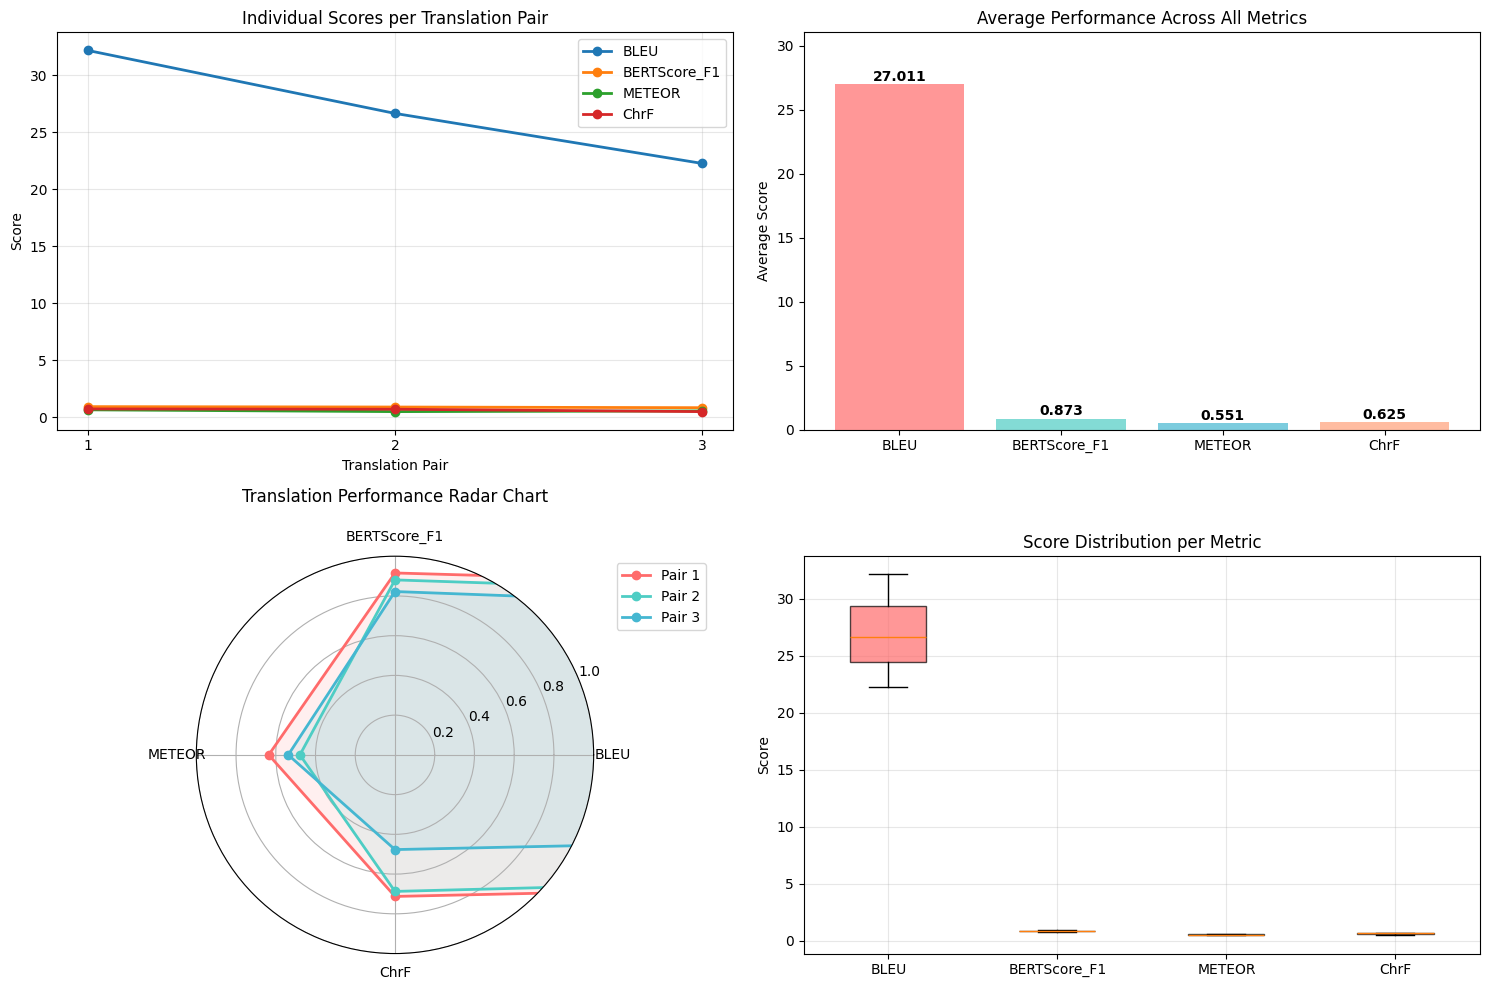


=== SUMMARY STATISTICS ===
BLEU:
  Mean: 27.0114
  Std:  4.0574
  Min:  22.2425
  Max:  32.1594

BERTScore_F1:
  Mean: 0.8728
  Std:  0.0386
  Min:  0.8221
  Max:  0.9156

METEOR:
  Mean: 0.5505
  Std:  0.0648
  Min:  0.4786
  Max:  0.6356

ChrF:
  Mean: 0.6255
  Std:  0.1057
  Min:  0.4767
  Max:  0.7125



In [23]:

visualize_translation_metrics(results)